X_train tensor shape: (2000, 28, 2)
T_train tensor shape: (2000, 28, 1)
x1: 1010010000101111100000110101 (180483109)
x2: - 0011000111110100111001100001 (140980108)
---
t:  = 1001100100100011010110100100 (39503001)
Sprawdzanie gradientu...
Brak błędów gradientu.
Iteracja 0, strata: 0.730606
Iteracja 100, strata: 0.000164
Iteracja 200, strata: 0.000068
Iteracja 300, strata: 0.000043
Iteracja 400, strata: 0.000031
Iteracja 500, strata: 0.000025
Iteracja 600, strata: 0.000021
Iteracja 700, strata: 0.000018
Iteracja 800, strata: 0.000015
Iteracja 900, strata: 0.000014


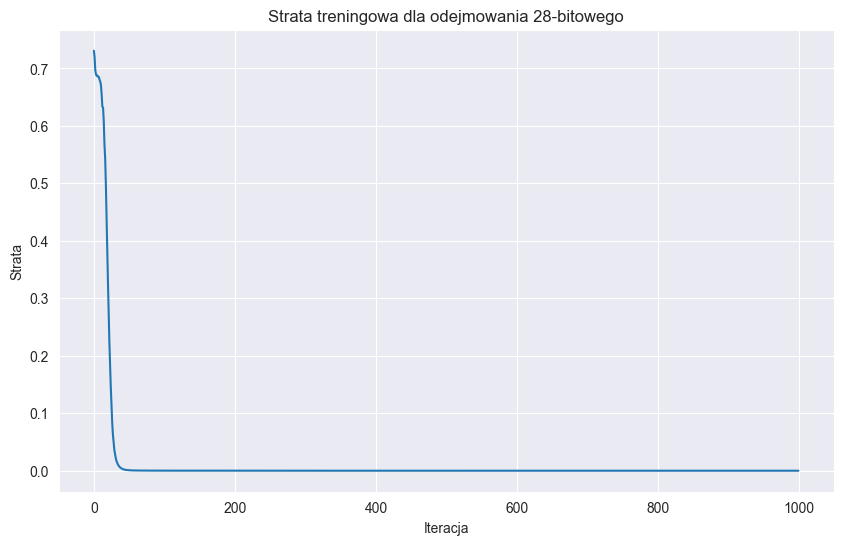

x1: 1100011110100101011011111001 (167159267)
x2: - 0000110100100011111010110110 (114803888)
---
t:  = 1100110010000111011110001100 (52355379)
y:  = 1100110010000111011110001100

x1: 0101110011011011010011011100 (62053178)
x2: - 0101100010111001110010001000 (18062618)
---
t:  = 0000010001111100111110010100 (43990560)
y:  = 0000010001111100111110010100

x1: 0111110100010001100011000101 (171018430)
x2: - 0011010100101111100011011100 (61994156)
---
t:  = 0100100000101001111111100110 (109024274)
y:  = 0100100000101001111111100110

x1: 0011100110011100000111011100 (62405020)
x2: - 0100100100001010011010100100 (39211154)
---
t:  = 0101000010010111100001101000 (23193866)
y:  = 0101000010010111100001101000

x1: 1100000001111011111101100100 (40885763)
x2: - 1011111111001000100111010000 (12129277)
---
t:  = 0110000001010011011011011000 (28756486)
y:  = 0110000001010011011011011000

Dokładność na 500 próbkach testowych: 100.00%


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(seed=1)

# Ustawienia dla 28-bitowych liczb
sequence_len = 28  # Długość sekwencji binarnej (28 bitów)
nb_train = 2000  # Liczba próbek treningowych

def create_dataset_subtraction(nb_samples, sequence_len):
    """
    Tworzy zbiór danych dla odejmowania binarnego.
    Format: t_i = x_i1 - x_i2 (z zachowaniem kolejności).
    """
    max_int = 2**(sequence_len)  # Max wartość dla sequence_len bitów
    format_str = '{:0' + str(sequence_len) + 'b}'
    nb_inputs = 2  # Dwie liczby do odejmowania
    nb_outputs = 1  # Jedna liczba wynikowa

    # Tensory wejściowe i docelowe
    X = np.zeros((nb_samples, sequence_len, nb_inputs))
    T = np.zeros((nb_samples, sequence_len, nb_outputs))

    for i in range(nb_samples):
        # Generuj dwie liczby: nb1 >= nb2, aby wynik był nieujemny
        nb1 = np.random.randint(0, max_int)
        nb2 = np.random.randint(0, nb1 + 1)  # nb2 <= nb1
        
        # Konwersja na binarne i odwrócenie (najmniej znaczący bit pierwszy)
        bin1 = list(reversed([int(b) for b in format_str.format(nb1)]))
        bin2 = list(reversed([int(b) for b in format_str.format(nb2)]))
        bin_diff = list(reversed([int(b) for b in format_str.format(nb1 - nb2)]))

        X[i, :, 0] = bin1
        X[i, :, 1] = bin2
        T[i, :, 0] = bin_diff
    
    return X, T

# Utworzenie zbioru treningowego
X_train, T_train = create_dataset_subtraction(nb_train, sequence_len)
print(f'X_train tensor shape: {X_train.shape}')
print(f'T_train tensor shape: {T_train.shape}')

def printSample(x1, x2, t, y=None):
    """Wizualizacja próbki."""
    x1_str = ''.join([str(int(d)) for d in x1])
    x1_val = int(''.join(reversed(x1_str)), 2)
    
    x2_str = ''.join([str(int(d)) for d in x2])
    x2_val = int(''.join(reversed(x2_str)), 2)
    
    t_str = ''.join([str(int(d[0])) for d in t])
    t_val = int(''.join(reversed(t_str)), 2)
    
    print(f'x1: {x1_str} ({x1_val})')
    print(f'x2: - {x2_str} ({x2_val})')
    print('---')
    print(f't:  = {t_str} ({t_val})')
    if y is not None:
        y_str = ''.join([str(int(d[0])) for d in y])
        print(f'y:  = {y_str}')

# Przykładowa próbka
printSample(X_train[0,:,0], X_train[0,:,1], T_train[0,:,:])

# Warstwa liniowa tensorowa
class TensorLinear(object):
    def __init__(self, n_in, n_out, tensor_order, W=None, b=None):
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = (np.random.uniform(-a, a, (n_in, n_out)) if W is None else W)
        self.b = (np.zeros((n_out)) if b is None else b)
        self.bpAxes = tuple(range(tensor_order - 1))

    def forward(self, X):
        return np.tensordot(X, self.W, axes=((-1), (0))) + self.b

    def backward(self, X, gY):
        gW = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB = np.sum(gY, axis=self.bpAxes)
        gX = np.tensordot(gY, self.W.T, axes=((-1), (0)))
        return gX, gW, gB

# Klasyfikator logistyczny
class LogisticClassifier(object):
    def forward(self, X):
        return 1.0 / (1.0 + np.exp(-X))
    
    def backward(self, Y, T):
        return (Y - T) / (Y.shape[0] * Y.shape[1])
    
    def loss(self, Y, T):
        return -np.mean(T * np.log(Y + 1e-8) + (1 - T) * np.log(1 - Y + 1e-8))

# Warstwa TanH
class TanH(object):
    def forward(self, X):
        return np.tanh(X)
    
    def backward(self, Y, output_grad):
        gTanh = 1.0 - (Y**2)
        return gTanh * output_grad

# Aktualizacja stanu rekurencyjnego
class RecurrentStateUpdate(object):
    def __init__(self, nbStates, W, b):
        self.linear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh = TanH()
    
    def forward(self, Xk, Sk):
        return self.tanh.forward(Xk + self.linear.forward(Sk))
    
    def backward(self, Sk0, Sk1, output_grad):
        gZ = self.tanh.backward(Sk1, output_grad)
        gSk0, gW, gB = self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gW, gB

# Rozwijanie stanów w czasie
class RecurrentStateUnfold(object):
    def __init__(self, nbStates, nbTimesteps):
        a = np.sqrt(6. / (nbStates * 2))
        self.W = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b = np.zeros((self.W.shape[0]))
        self.S0 = np.zeros(nbStates)
        self.nbTimesteps = nbTimesteps
        self.stateUpdate = RecurrentStateUpdate(nbStates, self.W, self.b)
    
    def forward(self, X):
        S = np.zeros((X.shape[0], X.shape[1] + 1, self.W.shape[0]))
        S[:, 0, :] = self.S0
        for k in range(self.nbTimesteps):
            S[:, k + 1, :] = self.stateUpdate.forward(X[:, k, :], S[:, k, :])
        return S
    
    def backward(self, X, S, gY):
        gSk = np.zeros_like(gY[:, self.nbTimesteps - 1, :])
        gZ = np.zeros_like(X)
        gWSum = np.zeros_like(self.W)
        gBSum = np.zeros_like(self.b)
        for k in range(self.nbTimesteps - 1, -1, -1):
            gSk += gY[:, k, :]
            gZ[:, k, :], gSk, gW, gB = self.stateUpdate.backward(
                S[:, k, :], S[:, k + 1, :], gSk)
            gWSum += gW
            gBSum += gB
        gS0 = np.sum(gSk, axis=0)
        return gZ, gWSum, gBSum, gS0

# Pełna sieć RNN dla odejmowania binarnego
class RnnBinarySubtractor(object):
    def __init__(self, nb_of_inputs, nb_of_outputs, nb_of_states, sequence_len):
        self.tensorInput = TensorLinear(nb_of_inputs, nb_of_states, 3)
        self.rnnUnfold = RecurrentStateUnfold(nb_of_states, sequence_len)
        self.tensorOutput = TensorLinear(nb_of_states, nb_of_outputs, 3)
        self.classifier = LogisticClassifier()
        self.sequence_len = sequence_len
    
    def forward(self, X):
        recIn = self.tensorInput.forward(X)
        S = self.rnnUnfold.forward(recIn)
        Z = self.tensorOutput.forward(S[:, 1:self.sequence_len + 1, :])
        Y = self.classifier.forward(Z)
        return recIn, S, Z, Y
    
    def backward(self, X, Y, recIn, S, T):
        gZ = self.classifier.backward(Y, T)
        gRecOut, gWout, gBout = self.tensorOutput.backward(
            S[:, 1:self.sequence_len + 1, :], gZ)
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(
            recIn, S, gRecOut)
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0
    
    def getOutput(self, X):
        _, _, _, Y = self.forward(X)
        return Y
    
    def getBinaryOutput(self, X):
        return np.around(self.getOutput(X))
    
    def getParamGrads(self, X, T):
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(
            X, Y, recIn, S, T)
        return [g for g in itertools.chain(
            np.nditer(gS0),
            np.nditer(gWin),
            np.nditer(gBin),
            np.nditer(gWrec),
            np.nditer(gBrec),
            np.nditer(gWout),
            np.nditer(gBout))]
    
    def loss(self, Y, T):
        return self.classifier.loss(Y, T)
    
    def get_params_iter(self):
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))

# Kontrola gradientu
print("Sprawdzanie gradientu...")
RNN = RnnBinarySubtractor(2, 1, 3, sequence_len)
backprop_grads = RNN.getParamGrads(X_train[0:100, :, :], T_train[0:100, :, :])

eps = 1e-7
for p_idx, param in enumerate(RNN.get_params_iter()):
    grad_backprop = backprop_grads[p_idx]
    param += eps
    plus_loss = RNN.loss(RNN.getOutput(X_train[0:100, :, :]), T_train[0:100, :, :])
    param -= 2 * eps
    min_loss = RNN.loss(RNN.getOutput(X_train[0:100, :, :]), T_train[0:100, :, :])
    param += eps
    grad_num = (plus_loss - min_loss) / (2 * eps)
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError(f'Nieprawidłowy gradient: num={grad_num:.6f}, backprop={grad_backprop:.6f}')

print('Brak błędów gradientu.')

# Trenowanie z RMSProp + Momentum Nesterova
lmda = 0.5
learning_rate = 0.05
momentum_term = 0.80
eps = 1e-6
mb_size = 100

nb_of_states = 3
RNN = RnnBinarySubtractor(2, 1, nb_of_states, sequence_len)

# Inicjalizacja RMSProp
params = list(RNN.get_params_iter())
V = [np.zeros_like(p.copy()) for p in params]
MA = [np.zeros_like(p.copy()) for p in params]

# Trenowanie
losses = []
n_iter = 1000
for i in range(n_iter):
    # Mini-batch
    idx = np.random.randint(0, X_train.shape[0], mb_size)
    X_mb = X_train[idx]
    T_mb = T_train[idx]
    
    # Pobierz gradienty
    grads = RNN.getParamGrads(X_mb, T_mb)
    
    # Aktualizuj MA i V (RMSProp + Nesterov)
    for p_idx, param in enumerate(params):
        # RMSProp: średnia ruchoma kwadratów gradientu
        MA[p_idx] = lmda * MA[p_idx] + (1 - lmda) * (grads[p_idx] ** 2)
        ma_sqrt = np.sqrt(MA[p_idx] + eps)
        norm_grad = grads[p_idx] / ma_sqrt
        
        # Nesterov momentum
        V[p_idx] = momentum_term * V[p_idx] - learning_rate * norm_grad
        param += V[p_idx]
    
    # Strata
    Y_mb = RNN.getOutput(X_mb)
    loss_val = RNN.loss(Y_mb, T_mb)
    losses.append(loss_val)
    
    if i % 100 == 0:
        print(f'Iteracja {i}, strata: {loss_val:.6f}')

# Wykres straty
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Iteracja')
plt.ylabel('Strata')
plt.title('Strata treningowa dla odejmowania 28-bitowego')
plt.grid(True)
plt.show()

# Testowanie
nb_test = 5
X_test, T_test = create_dataset_subtraction(nb_test, sequence_len)
Y_test = RNN.getBinaryOutput(X_test)
Yf_test = RNN.getOutput(X_test)

for i in range(X_test.shape[0]):
    printSample(X_test[i, :, 0], X_test[i, :, 1], T_test[i, :, :], Y_test[i, :, :])
    print('')

# Dokładność na zbiorze testowym
def binary_accuracy(Y_bin, T):
    Y_bin = Y_bin.astype(int)
    T_bin = T.astype(int)
    return np.mean(Y_bin == T_bin)

X_test_full, T_test_full = create_dataset_subtraction(500, sequence_len)
Y_test_full = RNN.getBinaryOutput(X_test_full)
acc = binary_accuracy(Y_test_full, T_test_full)
print(f'Dokładność na 500 próbkach testowych: {acc * 100:.2f}%')